<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [4]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb
'''taken from discussion in DL chat'''
! pip3 install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://yadi.sk/d/b4nAwIE73TVcp5) -o handout.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  843M  100  843M    0     0  28.1M      0  0:00:29  0:00:29 --:--:-- 33.3M


In [0]:
'''https://docs.python.org/3/library/tarfile.html'''
import tarfile
tf = tarfile.open("handout.tar.gz")
tf.extractall()

### Data preprocessing

In [6]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 182 ms, sys: 665 ms, total: 847 ms
Wall time: 848 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [7]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter


# Compute word frequencies for each word in captions. See code above for data structure
word_counts = Counter([captions[i][j][k] for i in range(len(captions)) for j in range(len(captions[i])) for k in range(len(captions[i][j]))])

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out[0])
        
        return logits        

In [0]:
network = CaptionNet(n_tokens)
network = network.cuda()

In [80]:
dummy_img_vec = torch.randn(len(captions[0]), 2048).cuda()
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64).cuda()

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    

    # apply the network, get predictions for captions_ix_next
    image_vectors = image_vectors.cuda()
    captions_ix_next = captions_ix_next.cuda()
    logits_for_next = network.forward(image_vectors, captions_ix_inp.cuda())
    logits_for_next = logits_for_next.transpose(1, 2)  

    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(logits_for_next, captions_ix_next, ignore_index = pad_ix).reshape(1)

    return loss

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)
assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.cpu().data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
optimizer = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).cuda(), torch.tensor(batch_captions_ix, dtype=torch.int64).cuda()
    

In [89]:
generate_batch(img_codes,captions,3)

(tensor([[0.2268, 0.2965, 0.2607,  ..., 0.2855, 0.1984, 0.6694],
         [0.1657, 0.2137, 0.5577,  ..., 0.1583, 0.7962, 0.1385],
         [0.0244, 0.4449, 0.3287,  ..., 0.1264, 0.3776, 0.0618]],
        device='cuda:0'),
 tensor([[   1,   24,  158,    6,   24,  169,   58,   24,  154,   15, 2177,   12,
             2,    3,    3],
         [   1, 1391,   94,    6,   45,   36,   35,   37,  123,   51,  110, 1300,
            12,    2,    3],
         [   1,   24,   29,   44, 4301,    6,   45,   36,   35,   24,  359,   14,
            37,   12,    2]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [91]:
from tqdm import tqdm
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

 10%|█         | 5/50 [00:00<00:00, 46.71it/s]


Epoch: 0, train loss: 6.038581352233887, val loss: 4.864350891113281


 14%|█▍        | 7/50 [00:00<00:00, 63.26it/s]


Epoch: 1, train loss: 4.715144739151001, val loss: 4.587441158294678


 14%|█▍        | 7/50 [00:00<00:00, 64.65it/s]


Epoch: 2, train loss: 4.468943681716919, val loss: 4.33262996673584


 14%|█▍        | 7/50 [00:00<00:00, 61.76it/s]


Epoch: 3, train loss: 4.2615584993362425, val loss: 4.079977941513062


 14%|█▍        | 7/50 [00:00<00:00, 64.76it/s]


Epoch: 4, train loss: 4.121808438301087, val loss: 4.004292345046997


 14%|█▍        | 7/50 [00:00<00:00, 63.37it/s]


Epoch: 5, train loss: 3.9999354696273803, val loss: 3.992435169219971


 14%|█▍        | 7/50 [00:00<00:00, 59.67it/s]


Epoch: 6, train loss: 3.892412247657776, val loss: 3.8992987632751466


 14%|█▍        | 7/50 [00:00<00:00, 68.02it/s]


Epoch: 7, train loss: 3.7974887180328367, val loss: 3.7639222145080566


 14%|█▍        | 7/50 [00:00<00:00, 65.66it/s]


Epoch: 8, train loss: 3.7491477346420288, val loss: 3.6514429092407226


 14%|█▍        | 7/50 [00:00<00:00, 62.33it/s]


Epoch: 9, train loss: 3.6875488710403443, val loss: 3.477693796157837


 14%|█▍        | 7/50 [00:00<00:00, 61.78it/s]


Epoch: 10, train loss: 3.649728856086731, val loss: 3.5343852996826173


 14%|█▍        | 7/50 [00:00<00:00, 63.66it/s]


Epoch: 11, train loss: 3.5651697301864624, val loss: 3.6393550872802733


 14%|█▍        | 7/50 [00:00<00:00, 66.43it/s]


Epoch: 12, train loss: 3.488794960975647, val loss: 3.543831157684326


 10%|█         | 5/50 [00:00<00:00, 47.41it/s]


Epoch: 13, train loss: 3.456772232055664, val loss: 3.444001865386963


 14%|█▍        | 7/50 [00:00<00:00, 63.91it/s]


Epoch: 14, train loss: 3.397602744102478, val loss: 3.4969707489013673


 14%|█▍        | 7/50 [00:00<00:00, 62.54it/s]


Epoch: 15, train loss: 3.3485994005203246, val loss: 3.464776706695557


 14%|█▍        | 7/50 [00:00<00:00, 69.76it/s]


Epoch: 16, train loss: 3.3280705976486207, val loss: 3.144985246658325


 16%|█▌        | 8/50 [00:00<00:00, 69.48it/s]


Epoch: 17, train loss: 3.2838398838043212, val loss: 3.297087049484253


 14%|█▍        | 7/50 [00:00<00:00, 64.71it/s]


Epoch: 18, train loss: 3.2183889675140382, val loss: 3.291133737564087


 14%|█▍        | 7/50 [00:00<00:00, 62.08it/s]


Epoch: 19, train loss: 3.2408083724975585, val loss: 3.087098503112793


 14%|█▍        | 7/50 [00:00<00:00, 66.09it/s]


Epoch: 20, train loss: 3.21543963432312, val loss: 3.254614782333374


 14%|█▍        | 7/50 [00:00<00:00, 68.20it/s]


Epoch: 21, train loss: 3.1569145774841307, val loss: 3.001961278915405


 12%|█▏        | 6/50 [00:00<00:00, 52.20it/s]


Epoch: 22, train loss: 3.136013069152832, val loss: 3.110587453842163


 14%|█▍        | 7/50 [00:00<00:00, 67.33it/s]


Epoch: 23, train loss: 3.1575558948516846, val loss: 3.1488907814025877


 12%|█▏        | 6/50 [00:00<00:00, 58.72it/s]


Epoch: 24, train loss: 3.135145220756531, val loss: 3.1934990882873535


 12%|█▏        | 6/50 [00:00<00:00, 59.85it/s]


Epoch: 25, train loss: 3.1237428474426268, val loss: 3.064897298812866


 14%|█▍        | 7/50 [00:00<00:00, 68.28it/s]


Epoch: 26, train loss: 3.0840143156051636, val loss: 3.0344703674316404


 16%|█▌        | 8/50 [00:00<00:00, 71.05it/s]


Epoch: 27, train loss: 3.0740736627578737, val loss: 2.9362110137939452


 14%|█▍        | 7/50 [00:00<00:00, 68.35it/s]


Epoch: 28, train loss: 3.0439563608169555, val loss: 3.062996673583984


 14%|█▍        | 7/50 [00:00<00:00, 58.84it/s]


Epoch: 29, train loss: 2.9969375562667846, val loss: 3.001768159866333


 14%|█▍        | 7/50 [00:00<00:00, 64.54it/s]


Epoch: 30, train loss: 3.0342663955688476, val loss: 3.064523696899414


 14%|█▍        | 7/50 [00:00<00:00, 60.10it/s]


Epoch: 31, train loss: 3.012962565422058, val loss: 2.9821629524230957


 14%|█▍        | 7/50 [00:00<00:00, 62.61it/s]


Epoch: 32, train loss: 3.0019942903518677, val loss: 2.994549036026001


 16%|█▌        | 8/50 [00:00<00:00, 66.51it/s]


Epoch: 33, train loss: 2.9884184646606444, val loss: 2.9437187194824217


 14%|█▍        | 7/50 [00:00<00:00, 66.97it/s]


Epoch: 34, train loss: 2.9345437574386595, val loss: 2.993883180618286


 12%|█▏        | 6/50 [00:00<00:00, 58.94it/s]


Epoch: 35, train loss: 2.948608708381653, val loss: 2.9558095932006836


 16%|█▌        | 8/50 [00:00<00:00, 70.83it/s]


Epoch: 36, train loss: 2.95909414768219, val loss: 3.029040288925171


 12%|█▏        | 6/50 [00:00<00:00, 51.47it/s]


Epoch: 37, train loss: 2.9224920654296875, val loss: 2.934069108963013


 14%|█▍        | 7/50 [00:00<00:00, 60.73it/s]


Epoch: 38, train loss: 2.924717526435852, val loss: 3.017853260040283


 12%|█▏        | 6/50 [00:00<00:00, 53.01it/s]


Epoch: 39, train loss: 2.9604310035705566, val loss: 2.9516879081726075


 12%|█▏        | 6/50 [00:00<00:00, 59.83it/s]


Epoch: 40, train loss: 2.9436065196990966, val loss: 2.9463791847229004


 14%|█▍        | 7/50 [00:00<00:00, 63.68it/s]


Epoch: 41, train loss: 2.929696226119995, val loss: 2.8674344062805175


 12%|█▏        | 6/50 [00:00<00:00, 58.36it/s]


Epoch: 42, train loss: 2.8757161045074464, val loss: 2.9340169429779053


 12%|█▏        | 6/50 [00:00<00:00, 54.25it/s]


Epoch: 43, train loss: 2.877610034942627, val loss: 2.8467403411865235


 14%|█▍        | 7/50 [00:00<00:00, 63.52it/s]


Epoch: 44, train loss: 2.885290951728821, val loss: 2.864399766921997


 14%|█▍        | 7/50 [00:00<00:00, 63.11it/s]


Epoch: 45, train loss: 2.8820470142364503, val loss: 2.869251251220703


 12%|█▏        | 6/50 [00:00<00:00, 56.40it/s]


Epoch: 46, train loss: 2.836023278236389, val loss: 2.938642692565918


 12%|█▏        | 6/50 [00:00<00:00, 57.55it/s]


Epoch: 47, train loss: 2.9118356132507324, val loss: 2.943701219558716


 12%|█▏        | 6/50 [00:00<00:00, 57.48it/s]


Epoch: 48, train loss: 2.845210618972778, val loss: 2.9802079677581785


 12%|█▏        | 6/50 [00:00<00:00, 59.30it/s]


Epoch: 49, train loss: 2.86021755695343, val loss: 2.859607982635498


 14%|█▍        | 7/50 [00:00<00:00, 68.83it/s]


Epoch: 50, train loss: 2.8430081605911255, val loss: 2.9303532600402833


 12%|█▏        | 6/50 [00:00<00:00, 59.72it/s]


Epoch: 51, train loss: 2.826710319519043, val loss: 2.8938475131988524


 14%|█▍        | 7/50 [00:00<00:00, 60.29it/s]


Epoch: 52, train loss: 2.824049463272095, val loss: 2.8416458129882813


 12%|█▏        | 6/50 [00:00<00:00, 53.18it/s]


Epoch: 53, train loss: 2.832210922241211, val loss: 2.766259288787842


 14%|█▍        | 7/50 [00:00<00:00, 63.83it/s]


Epoch: 54, train loss: 2.7692042779922486, val loss: 2.798154592514038


 14%|█▍        | 7/50 [00:00<00:00, 58.81it/s]


Epoch: 55, train loss: 2.7724096727371217, val loss: 2.8263579845428466


 14%|█▍        | 7/50 [00:00<00:00, 64.82it/s]


Epoch: 56, train loss: 2.786844348907471, val loss: 2.9338353157043455


 12%|█▏        | 6/50 [00:00<00:00, 54.04it/s]


Epoch: 57, train loss: 2.772757019996643, val loss: 2.7734110355377197


 12%|█▏        | 6/50 [00:00<00:00, 59.72it/s]


Epoch: 58, train loss: 2.773189215660095, val loss: 2.721533727645874


 12%|█▏        | 6/50 [00:00<00:00, 54.17it/s]


Epoch: 59, train loss: 2.7553471088409425, val loss: 2.7523065567016602


 14%|█▍        | 7/50 [00:00<00:00, 64.64it/s]


Epoch: 60, train loss: 2.726262331008911, val loss: 2.8438388824462892


 14%|█▍        | 7/50 [00:00<00:00, 63.44it/s]


Epoch: 61, train loss: 2.7721557664871215, val loss: 2.910555934906006


 14%|█▍        | 7/50 [00:00<00:00, 62.65it/s]


Epoch: 62, train loss: 2.7372302341461183, val loss: 2.8143433570861816


 12%|█▏        | 6/50 [00:00<00:00, 57.41it/s]


Epoch: 63, train loss: 2.7468936824798584, val loss: 2.7366384983062746


 12%|█▏        | 6/50 [00:00<00:00, 53.72it/s]


Epoch: 64, train loss: 2.748236126899719, val loss: 2.722869300842285


 14%|█▍        | 7/50 [00:00<00:00, 65.33it/s]


Epoch: 65, train loss: 2.741262788772583, val loss: 2.8061008930206297


 14%|█▍        | 7/50 [00:00<00:00, 62.77it/s]


Epoch: 66, train loss: 2.7691523170471193, val loss: 2.8090247631073


 14%|█▍        | 7/50 [00:00<00:00, 60.40it/s]


Epoch: 67, train loss: 2.7224222660064696, val loss: 2.7257854461669924


 12%|█▏        | 6/50 [00:00<00:00, 58.29it/s]


Epoch: 68, train loss: 2.731003384590149, val loss: 2.76334171295166


 12%|█▏        | 6/50 [00:00<00:00, 56.88it/s]


Epoch: 69, train loss: 2.6820866870880127, val loss: 2.7358579635620117


 14%|█▍        | 7/50 [00:00<00:00, 68.10it/s]


Epoch: 70, train loss: 2.7378430938720704, val loss: 2.7880836486816407


 12%|█▏        | 6/50 [00:00<00:00, 59.99it/s]


Epoch: 71, train loss: 2.7298378944396973, val loss: 2.7198384284973143


 14%|█▍        | 7/50 [00:00<00:00, 66.83it/s]


Epoch: 72, train loss: 2.742900166511536, val loss: 2.7945829391479493


 14%|█▍        | 7/50 [00:00<00:00, 63.72it/s]


Epoch: 73, train loss: 2.702536826133728, val loss: 2.7600593090057375


 10%|█         | 5/50 [00:00<00:01, 43.99it/s]


Epoch: 74, train loss: 2.678673572540283, val loss: 2.680433511734009


 14%|█▍        | 7/50 [00:00<00:00, 62.52it/s]


Epoch: 75, train loss: 2.7224286651611327, val loss: 2.6926230907440187


 12%|█▏        | 6/50 [00:00<00:00, 52.75it/s]


Epoch: 76, train loss: 2.6835114908218385, val loss: 2.7606881618499757


 14%|█▍        | 7/50 [00:00<00:00, 68.06it/s]


Epoch: 77, train loss: 2.6649098873138426, val loss: 2.7646129608154295


 14%|█▍        | 7/50 [00:00<00:00, 59.90it/s]


Epoch: 78, train loss: 2.664575667381287, val loss: 2.701194143295288


 14%|█▍        | 7/50 [00:00<00:00, 59.17it/s]


Epoch: 79, train loss: 2.677039957046509, val loss: 2.6335520267486574


 12%|█▏        | 6/50 [00:00<00:00, 58.72it/s]


Epoch: 80, train loss: 2.6415541648864744, val loss: 2.68341064453125


 14%|█▍        | 7/50 [00:00<00:00, 65.27it/s]


Epoch: 81, train loss: 2.695178813934326, val loss: 2.664746809005737


 14%|█▍        | 7/50 [00:00<00:00, 65.99it/s]


Epoch: 82, train loss: 2.6755973625183107, val loss: 2.742984676361084


 14%|█▍        | 7/50 [00:00<00:00, 61.37it/s]


Epoch: 83, train loss: 2.7033604192733764, val loss: 2.68442702293396


 14%|█▍        | 7/50 [00:00<00:00, 62.78it/s]


Epoch: 84, train loss: 2.69677529335022, val loss: 2.6327466011047362


 14%|█▍        | 7/50 [00:00<00:00, 62.45it/s]


Epoch: 85, train loss: 2.6505534744262693, val loss: 2.744541645050049


 10%|█         | 5/50 [00:00<00:01, 44.35it/s]


Epoch: 86, train loss: 2.7103182172775266, val loss: 2.797638988494873


 14%|█▍        | 7/50 [00:00<00:00, 66.15it/s]


Epoch: 87, train loss: 2.6742315912246704, val loss: 2.553410768508911


 12%|█▏        | 6/50 [00:00<00:00, 54.93it/s]


Epoch: 88, train loss: 2.668338108062744, val loss: 2.6675085544586183


 12%|█▏        | 6/50 [00:00<00:00, 58.93it/s]


Epoch: 89, train loss: 2.623864107131958, val loss: 2.662847375869751


 12%|█▏        | 6/50 [00:00<00:00, 58.35it/s]


Epoch: 90, train loss: 2.651547546386719, val loss: 2.765950059890747


 12%|█▏        | 6/50 [00:00<00:00, 58.65it/s]


Epoch: 91, train loss: 2.6398649072647093, val loss: 2.6858473777770997


 12%|█▏        | 6/50 [00:00<00:00, 55.29it/s]


Epoch: 92, train loss: 2.620117201805115, val loss: 2.6542803764343263


 14%|█▍        | 7/50 [00:00<00:00, 65.64it/s]


Epoch: 93, train loss: 2.6333518266677856, val loss: 2.668147897720337


 14%|█▍        | 7/50 [00:00<00:00, 58.34it/s]


Epoch: 94, train loss: 2.655752172470093, val loss: 2.6909820079803466


 14%|█▍        | 7/50 [00:00<00:00, 66.01it/s]


Epoch: 95, train loss: 2.6401239442825317, val loss: 2.5528276920318604


 10%|█         | 5/50 [00:00<00:00, 47.22it/s]


Epoch: 96, train loss: 2.6467416524887084, val loss: 2.699048089981079


 14%|█▍        | 7/50 [00:00<00:00, 69.60it/s]


Epoch: 97, train loss: 2.671967668533325, val loss: 2.6934738159179688


 10%|█         | 5/50 [00:00<00:00, 49.16it/s]


Epoch: 98, train loss: 2.6041147089004517, val loss: 2.754509925842285


100%|██████████| 50/50 [00:00<00:00, 58.87it/s]


Epoch: 99, train loss: 2.652521643638611, val loss: 2.6274632453918456
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).cuda()
            next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [94]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2019-05-15 13:15:58--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.36.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.36.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K  --.-KB/s    in 0.01s   

2019-05-15 13:15:58 (9.15 MB/s) - ‘data/img.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


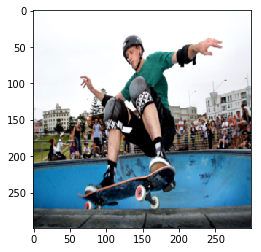

In [95]:
plt.imshow(img)

In [96]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard in the air .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .


--2019-05-15 13:16:08--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.02s   

2019-05-15 13:16:08 (6.22 MB/s) - ‘data/img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


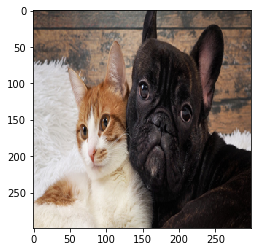

a cat is laying on a bed with a cat .
a cat that is sitting on a couch .
a cat that is sitting on a bed .
a cat is laying on a bed with a cat .
a cat is laying on a bed with a dog .
a cat that is sitting on a bed .
a cat is laying on a bed with a dog .
a cat is sitting on a couch with a remote control .
a cat is laying on a bed with a cat .
a cat is sitting on a chair in a room .


In [97]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [0]:
# apply your network on images you've found
#
#

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)